In [27]:
%matplotlib inline
%matplotlib ipympl
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [28]:
data = pd.read_csv('cardox.csv')
data

,date,value
0,1958-03-01,315.71
1,1958-04-01,317.45
2,1958-05-01,317.50
3,1958-06-01,317.10
4,1958-07-01,315.86
...,...,...
724,2018-07-01,408.71
725,2018-08-01,406.99
726,2018-09-01,405.51
727,2018-10-01,406.00


In [29]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.set_index('date', inplace=True)

In [30]:
data

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86
...,...
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 1958-03-01 to 2018-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   729 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [32]:
data.isnull().sum()

value    0
dtype: int64

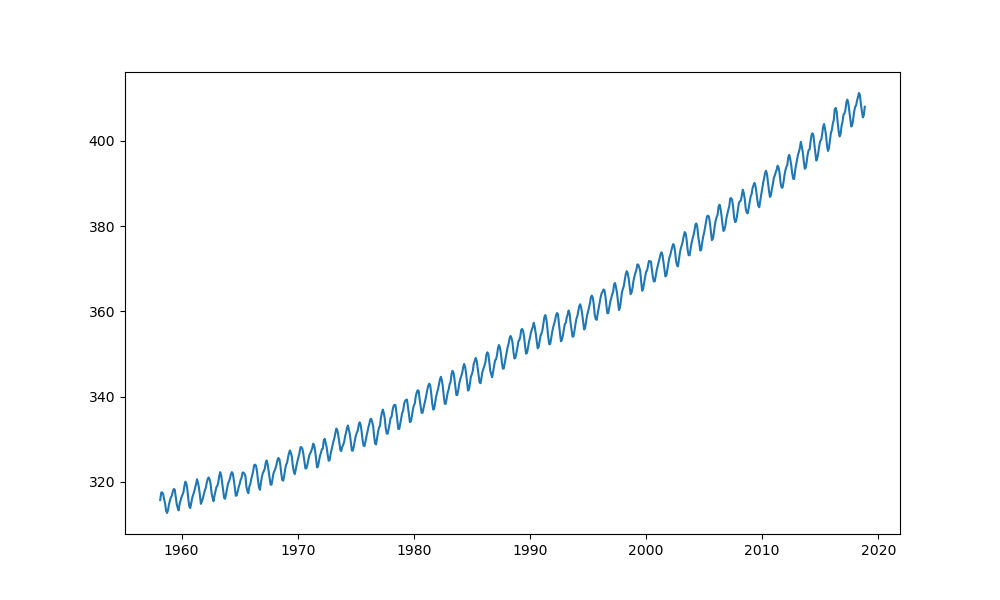

In [33]:
plt.figure(figsize=(10,6))
plt.plot(data)

Декомпозиція:

In [34]:
decom = seasonal_decompose(data)
decom

In [35]:
trend = decom.trend
seasonal = decom.seasonal
residual = decom.resid

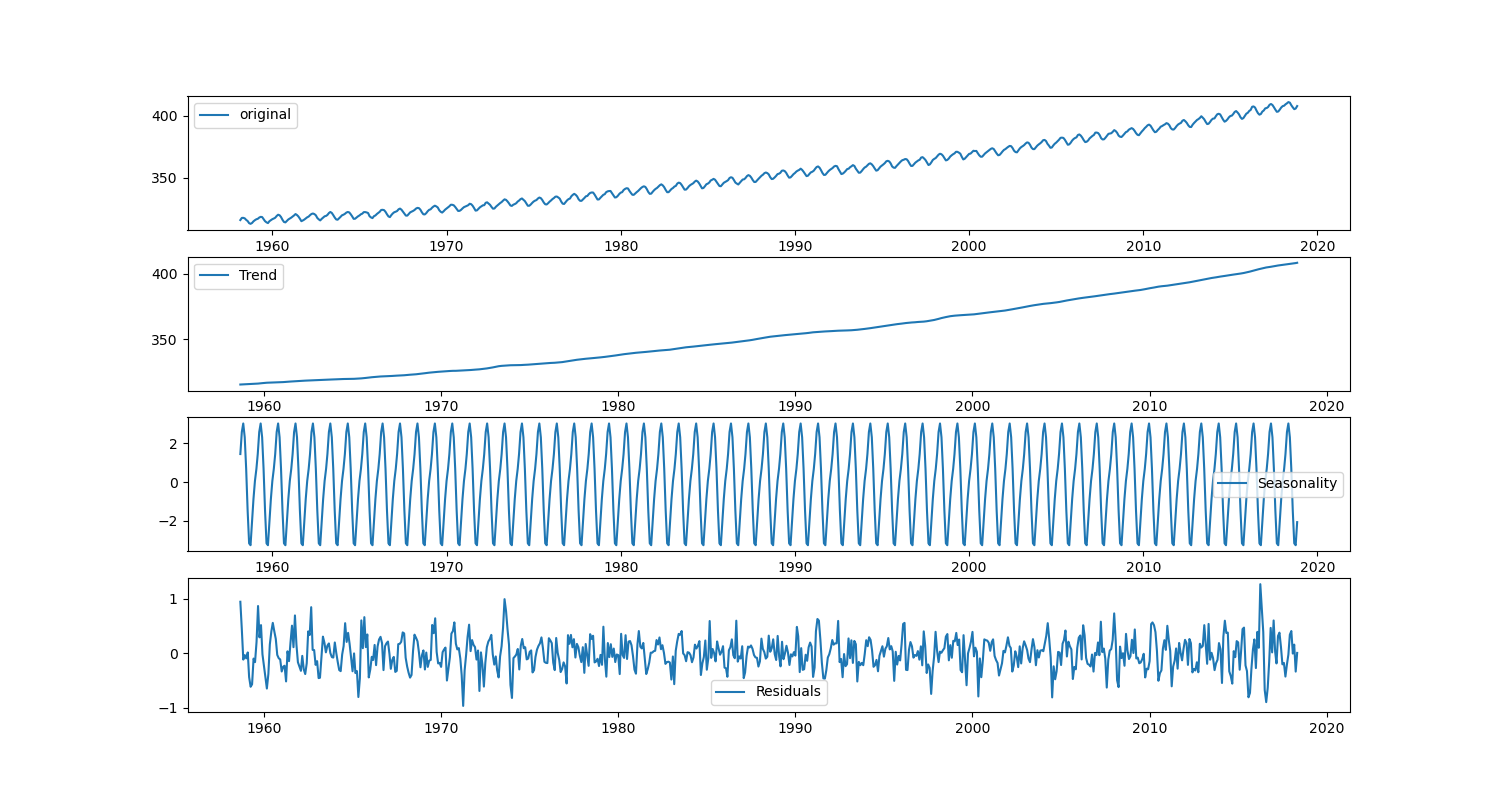

In [36]:
plt.figure(figsize=(15,8))
plt.subplot(411)
plt.plot(data, label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

Проведемо тест на стаціонарність (тест Дікі-Фуллера):

In [37]:
dftest = adfuller(data, autolag = 'AIC')
print(f'1. ADF: {dftest[0]}')
print(f'2. P-Value: {dftest[1]}')
print(f'3. Critical Values:')
for key, val in dftest[4].items():
    print(f'{key} : {val}')

1. ADF: 4.994847244403932
2. P-Value: 1.0
3. Critical Values:
1% : -3.439620010600208
5% : -2.8656309041017756
10% : -2.5689484851894413


In [38]:
data_diff = data - data.shift()
data_diff

,value
date,
1958-03-01,NaN
1958-04-01,1.74
1958-05-01,0.05
1958-06-01,-0.40
1958-07-01,-1.24
...,...
2018-07-01,-2.08
2018-08-01,-1.72
2018-09-01,-1.48


In [39]:
data_diff.dropna(inplace=True)
data_diff

,value
date,
1958-04-01,1.74
1958-05-01,0.05
1958-06-01,-0.40
1958-07-01,-1.24
1958-08-01,-0.93
...,...
2018-07-01,-2.08
2018-08-01,-1.72
2018-09-01,-1.48


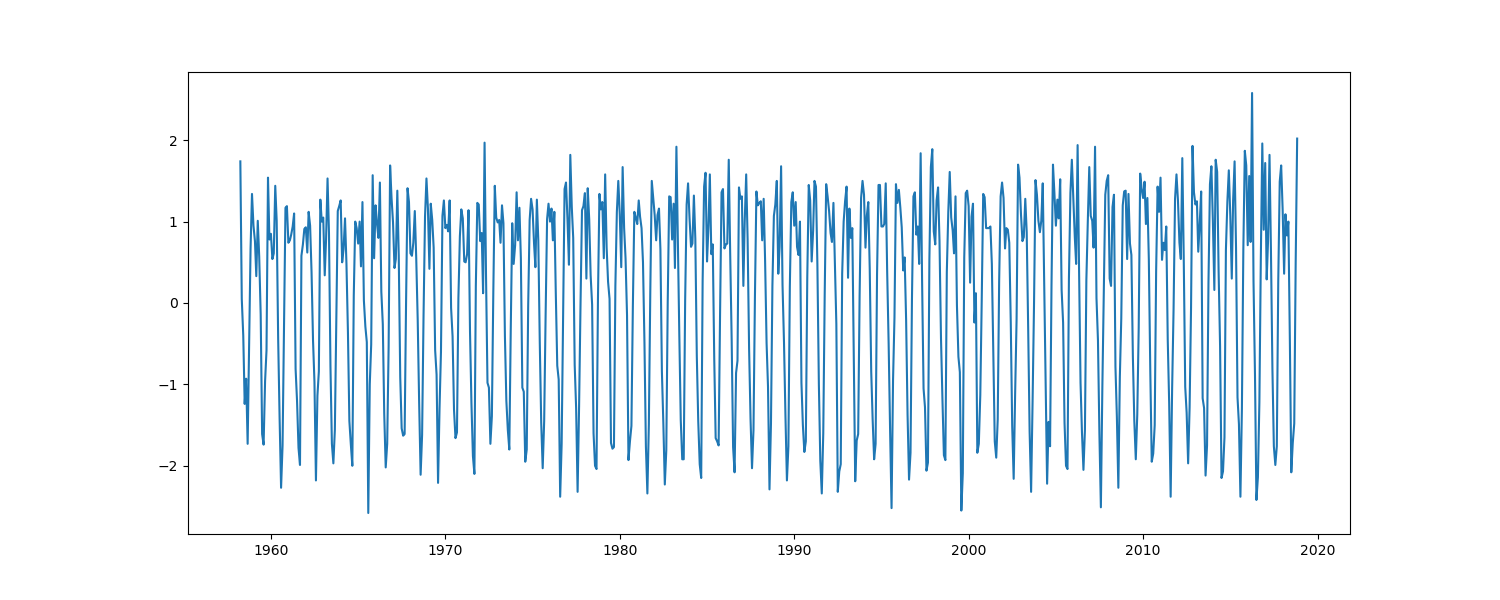

In [40]:
plt.figure(figsize=(15,6))
plt.plot(data_diff)

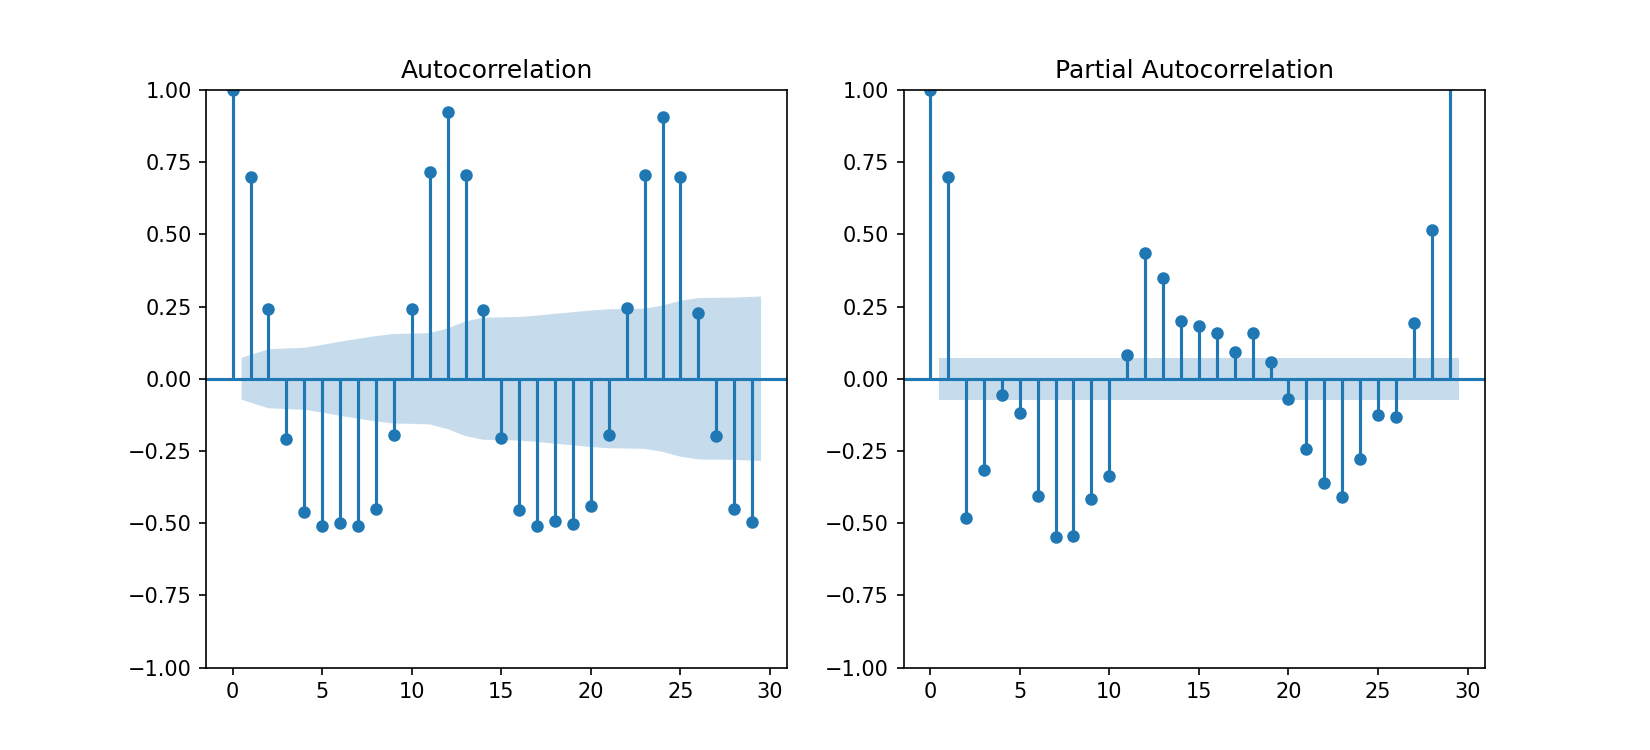

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5), dpi= 150)
plot_acf(data_diff, ax=axes[0])
plot_pacf(data_diff, ax=axes[1])
plt.show()

In [42]:
model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

In [43]:
model_fit.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.1941,0.083,2.353,0.019,0.032,0.356
ma.L1,-0.5579,0.071,-7.806,0.000,-0.698,-0.418
ar.S.L12,-0.0008,0.043,-0.018,0.986,-0.086,0.084
ma.S.L12,-0.8646,0.025,-34.515,0.000,-0.914,-0.816
sigma2,0.0958,0.005,20.460,0.000,0.087,0.105


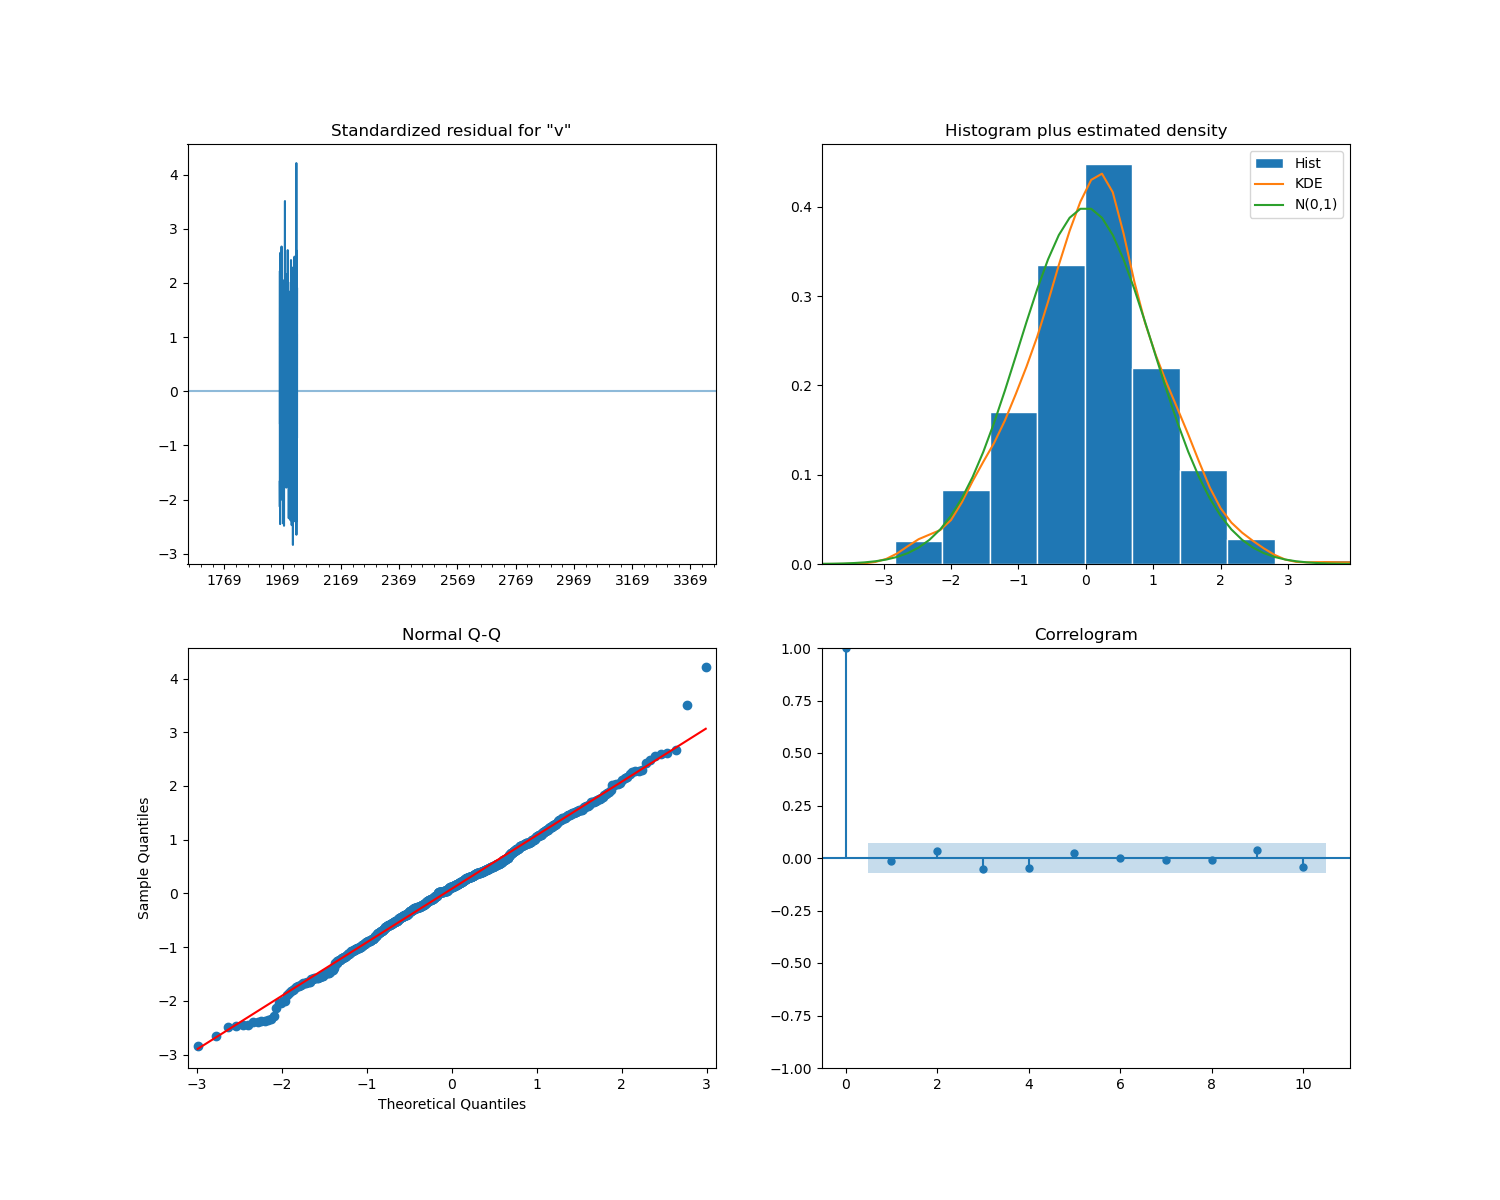

In [44]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [45]:
predict = model_fit.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
data_forecasted = predict.predicted_mean
data_truth = data.value['2010-01-01':]

In [46]:
mse = mean_squared_error(data_truth, data_forecasted)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.1296485770695812
Root Mean Squared Error (RMSE): 0.36006746183122573


Прогноз на 30 років:

In [47]:
predict_30_years = model_fit.get_prediction(start='2018-12-01', end='2048-11-01')
results = predict_30_years.predicted_mean

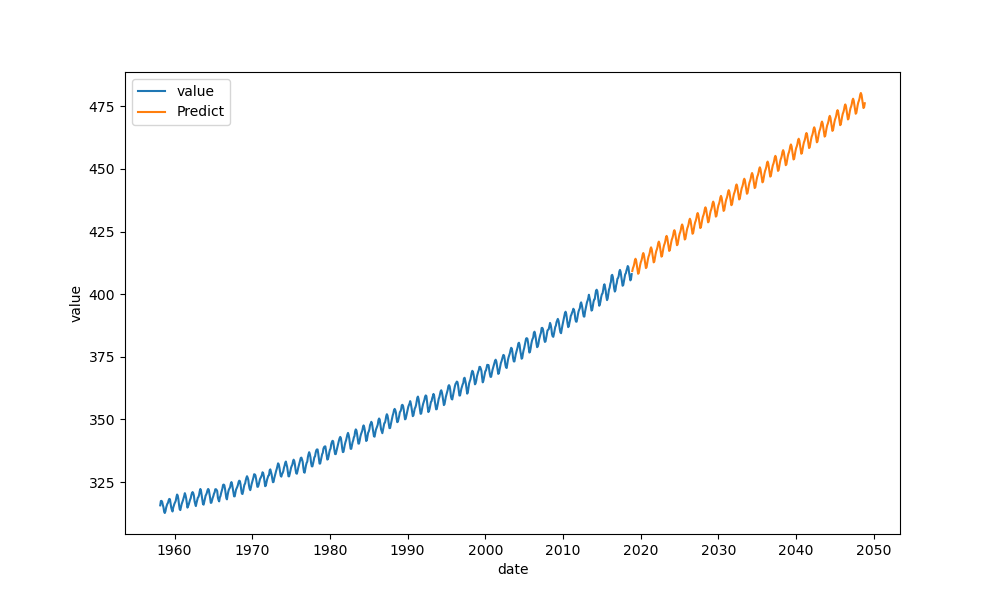

In [48]:
plt.figure(figsize=(10,6))
plt.plot(data, label='value')
plt.plot(predict_30_years.predicted_mean, label='Predict')
plt.xlabel("date")
plt.ylabel("value")
plt.legend()

In [49]:
results.to_csv('Results.csv')